In [2]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

In [1]:
import tensorflow_hub as hub
import cv2

* (참고) opencv, tensorflow_hub, keras, graphvis, pydot가 설치가 되어 있는지 확인!!!!

# Tensorflow-hub에 대해서 혹시 설치가 안 되어 있다면 설치하면 됨!!!! -> Anaconda Navigator 에서 설치하면 됨!!!

In [3]:
# 8.1 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


* 전체 네트워크에 대한 구조 출력 코드 :GraphViz + pydot설치 필요!!

14540800/14536120 [==============================] - 3s 0us/step


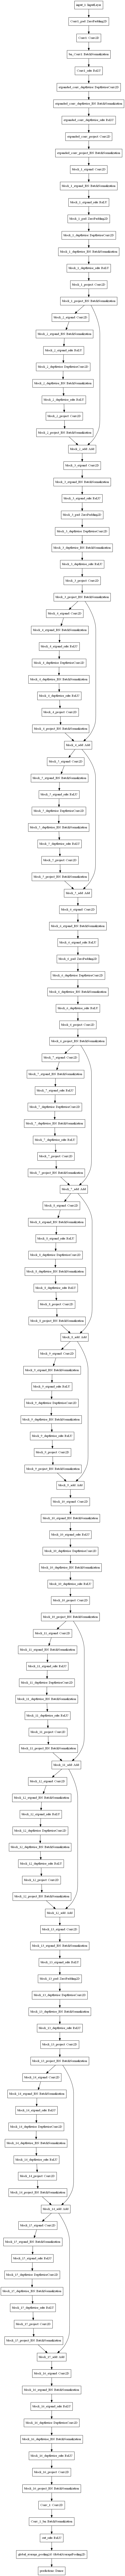

In [4]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드 ===> 뒤에 이 것으로 활용을 할 것임!!!
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

* ImageNetV2-TopImages  : 경로가 없으면 생성하고 하면 됨!!!! --> 혹시 설치 경로가 다르게 되면 다른 곳에 설치가 되고, 그러면 그 곳에 대한 경로를 확인해 주어야 함!!!!

<img src="img/img_29.png">

In [9]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib

# 기본 루트를 중심으로 아래 폴더가 없으면 생성을 하고 다운이 받아지는지 확인 필요!!!! ---> 
# 경로 : jupyter notebook을 중심으로 content 폴더, 그 아래 하위 sample_data 폴더 필요
# ---> 아래 이미 생성이 되어 있다면 아래 코드의 주석을 적용하면 되고,
# 파일이 다 안 되어 있다면 주석을 풀어서 진행을 하면 됨!!!!
content_data_url = 'content/sample_data'
# data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

1234968576/1234964480 [==============================] - 216s 0us/step
content\sample_data\datasets\imagenetv2-topimages


In [11]:
# 디렉토리 출력!! --> 1000개 이기 때문에 중간에서 짜르기 위해서...
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

content\sample_data\datasets\imagenetv2-topimages\0
content\sample_data\datasets\imagenetv2-topimages\1
content\sample_data\datasets\imagenetv2-topimages\10
content\sample_data\datasets\imagenetv2-topimages\100
content\sample_data\datasets\imagenetv2-topimages\101
content\sample_data\datasets\imagenetv2-topimages\102
content\sample_data\datasets\imagenetv2-topimages\103
content\sample_data\datasets\imagenetv2-topimages\104
content\sample_data\datasets\imagenetv2-topimages\105
content\sample_data\datasets\imagenetv2-topimages\106


* 8.4 ImageNet 라벨 텍스트 불러오기

In [12]:
# 
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

16384/10484 [==============================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


* 8.5 이미지 확인

image_count: 500


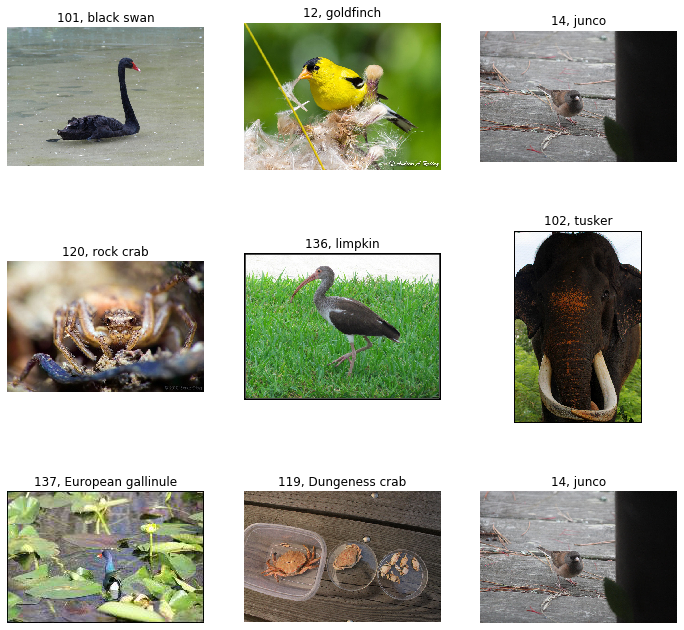

In [13]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]


# 뒤에 진행 등에서 너무 오래 걸리기에 위에 있는 것에 대해서 일부 추려서 진행을 함;;; ---> 1만개 모두 학습은 어려움;;;
# 500개만 추리게 됨;;;
all_image_paths = all_image_paths[:500]


# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    # Mac
#     idx = int(image_path.split('/')[-2]) + 1
    # Windows
    idx = int(image_path.split('\\')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

* 8.6 MobileNet의 분류 성능 확인 --> opencv설치 필요!!!

In [11]:
# 8.6 MobileNet의 분류 성능 확인
import cv2

top_1 = 0
top_5 = 0

# 위에서 all_image_apths에서 1만개에서 500개로 줄였음!!!!
# 해당하는 값들을 메모리에 담는 과정이기 때문에 PC 사양 등에 따라서 안될 수 있음;;;;
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('\\')[-2])+1      # 윈도우에서는 \\ , colab에서는 /
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness: 84.2 %
Top-1 correctness: 63.800000000000004 %


*참고 결과) 
<img src="img/img_32.png">

* 참고) numpy.argsort 기능 확은

In [13]:
# numpy.argsort() 설명 코드
a = np.array([99,32,5,64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


* MobileNet의 분류 라벨 확인

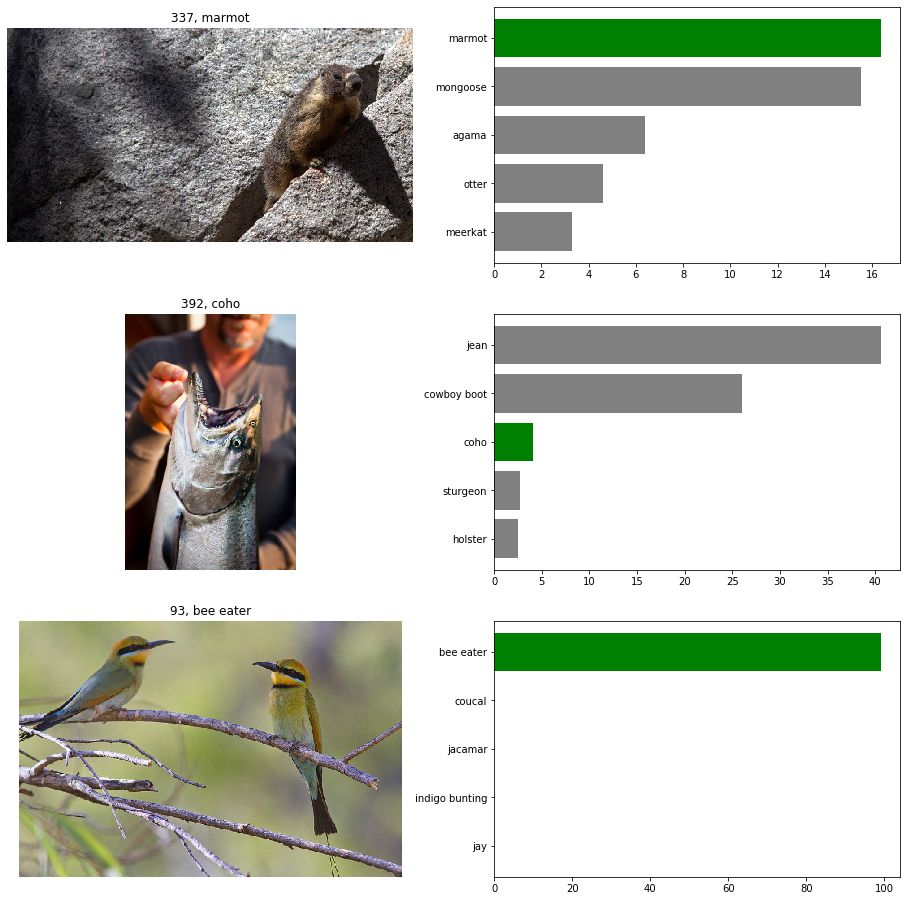

In [14]:
# 8.7 MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('\\')[-2]) + 1      # 윈도우에서는 \\ , colab에서는 /
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    

<img src="img/img_33.png">

# Transfer Learning

## 1) 모델의 일부를 재학습 해보자!!
* 아까 받은 경로에 아래와 같아 설치를 한다.
<img src="img/img_30.png">

In [15]:
# 8.8 Stanford Dog Dataset을 Kaggle에서 불러오기

# 체크!!!!!!)
# ---> 이미 앞에서 다운로드 하였으면 아래 코드 실행 안 할 것!!!


# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경되었습니다. 
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정되었습니다.
# ---> 파일 경로 설정하기!!!
# tf.keras.utils.get_file('C:/Users/user/python/content/labels.csv', 'http://bit.ly/2GDxsYS')
# tf.keras.utils.get_file('C:/Users/user/python/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
# tf.keras.utils.get_file('C:/Users/user/python/content/train.zip', 'http://bit.ly/31nIyel')
# tf.keras.utils.get_file('C:/Users/user/python/content/test.zip', 'http://bit.ly/2GHEsnO')


362848256/362841195 [==============================] - 33s 0us/step


'C:/Users/user/python/content/test.zip'

* 해당하는 파일들을 압출 풀기!!

In [ ]:
# colab 에서 압출 풀때
# !unzip -uq "압출을 풀려고 하는 파일의 경로" -d "압축을 푼 후의 파일 경로"

!unzip -uq "/content/driver/My Driv ~~~/train.zip" -d "/content/driver/My Driv ~~~/train"

* 파일 불러들이기!!

In [16]:
# 8.10 labels.csv 파일 내용 확인
import pandas as pd
label_text = pd.read_csv('content/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


*  Label정보 확인

In [16]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [17]:
# 8.12 견종 수 확인
label_text['breed'].nunique()

120

****** 뒤에 속도 및 메모리 부분으로 label_text를 좀 줄이기로 함;;;;;; 
참고) 가능하면 해도 되는데,,,,,메모리 및 모델 하는데 오래 걸리는 문제로 인하여 넘어가야 할 듯...

In [27]:
label_text = label_text
#label_text = label_text[:500]
print(len(label_text))
print(label_text['breed'].nunique())

# --> 102222
# --> 120

500
119


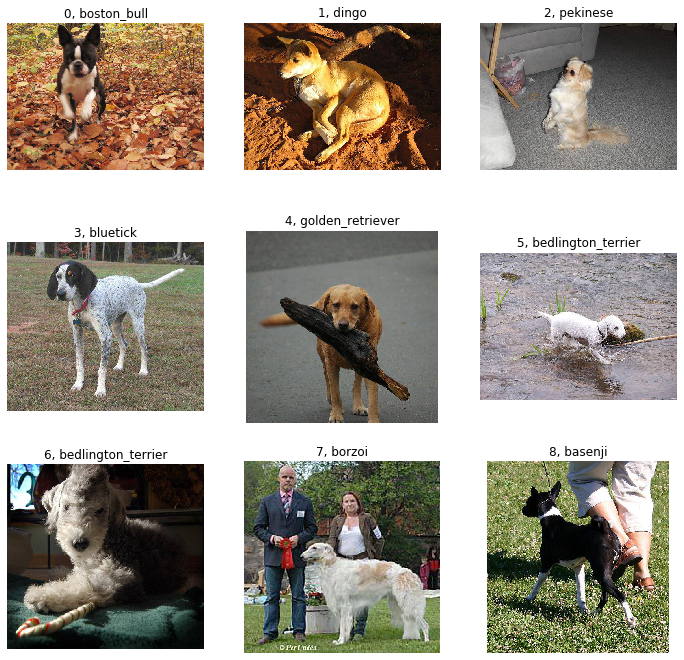

In [28]:
# 8.13 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

* 기존에 학습된 MobileNet V2를 불러오기!!!!(다른 사람이 잘 만든 모델 가져오기!!!!)

In [17]:
# 8.14 tf.keras에서 MobileNet V2 불러오기
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

* 불러온 모델의 가중치 초기화!!!

In [18]:
# 확인1) 우선 받은 모델의 layer 를 살펴보자!!!!
# 맨 앞은 input부터 시작을 하고, 맨 마지막 Dense로 이루어진 것을 볼 수있음!!!!!!!!!!
print(len(mobilev2.layers))
print(mobilev2.layers)

157
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A6D942A5C8>, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A6D9E0B648>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6D925F108>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A6D9E4FA08>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001A6D9422588>, <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x000001A6D9E4FFC8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A6D9E34CC8>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001A6D9692088>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6D6AF7A08>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A6D92E0888>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A6D92E23C8>

In [24]:
# 확인2) 아래 코드의 의미를 알아보자!!!!!--> 맨
print(len(mobilev2.layers[:-1]))
print(mobilev2.layers[:-1])

156
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x154b42890>, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x15430c390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x167acac10>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x154465050>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x167af3e90>, <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x154f73210>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x167b02190>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x166bafed0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x166bcb790>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x166bd6190>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1664b9b50>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1664cb0

In [25]:
# 8.15 MobileNet V2의 가중치 초기화
for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))        

* train 데이터 불러오기

In [29]:
# 8.16 train 데이터를 메모리에 로드
import cv2

train_X = []
for i in range(len(label_text)):
    img = cv2.imread('content/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    train_X.append(img)
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

(500, 224, 224, 3)
602112000  bytes


In [30]:
# 8.17 train 라벨 데이터를 메모리에 로드
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[92 25 33 90 21 79 26 91 45 65]


In [31]:
# 8.18 Dogs Dataset 학습을 위한 모델 정의 --> Mobile Net V2에서 마지막 Dense 레이어를 제외하기 위해서
# 뒤에서 두 번째 레이어를 지정을 해서 그 레이어의 output을 X라는 변수에 저장을 함.
# 그리고 그 뒤에 다시 개를 분류하기 위한 120개의 뉴련을 가진 Dense 레이어를 추가함.
x = mobilev2.layers[-2].output

# 특별한 원본 데이터 사용 시 : 120개 --> 앞의 것 500개 하면서 119개로 변경이 되어서...코드가 변경이 됨...
nClass = label_text['breed'].nunique()

predictions = tf.keras.layers.Dense(nClass, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [33]:
# 8.19 랜덤한 가중치를 가진 상태에서의 학습
history = model.fit(train_X, train_Y, epochs=1, validation_split=0.25, batch_size=32)

#history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

Train on 375 samples, validate on 125 samples
375/375 [==============================] - 145s 386ms/sample - loss: 4.9382 - accuracy: 0.0053 - val_loss: 11.1758 - val_accuracy: 0.0000e+00


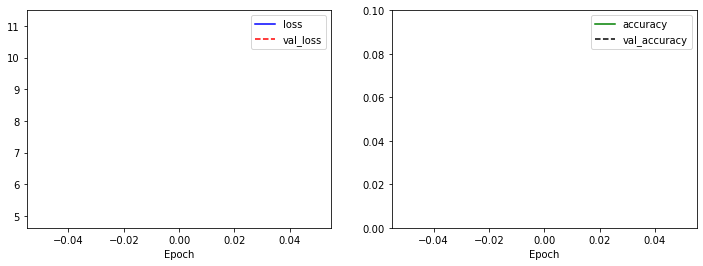

In [34]:
# 8.20 학습 결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend()

plt.show()

* 위의 결과는 1 epoch만 했기에 결과가;;;아래는 샘플 결과임.. --> overfitting의 결과임;; --> 학습이 엉망인 상태임;;;;ㅠㅠ
<img src="img/img_34.png">

* 이제는 전체를 다 하는 것이 아니라, 뒤에 20개만 훈련을 하고, 그 앞에는 기존의 가중치를 그대로 사용!!!!!!!

In [37]:
# 8.21 Dogs Dataset 학습을 위한 Transfer Learning 모델 정의
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()


# 특별한 원본 데이터 사용 시 : 120개 --> 앞의 것 500개 하면서 119개로 변경이 되어서...코드가 변경이 됨...
nClass = label_text['breed'].nunique()


x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(nClass, activation='softmax')(x)
#predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

Train on 375 samples, validate on 125 samples
375/375 [==============================] - 83s 223ms/sample - loss: 5.0557 - accuracy: 0.0053 - val_loss: 4.8615 - val_accuracy: 0.0000e+00


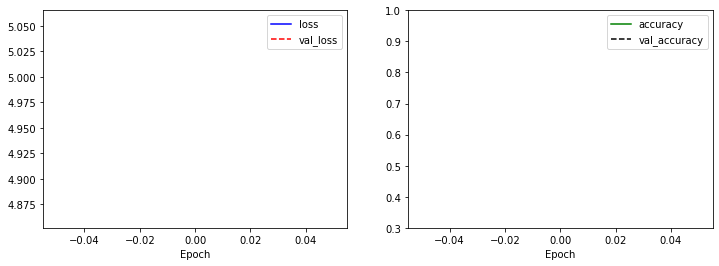

In [38]:
# 8.22 모델 학습 및 결과 확인

# 아래 코드가 너무 오래 걸리기 때문에...epoch=1로 줄여서 함;;;;;;
# history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)
history = model.fit(train_X, train_Y, epochs=1, validation_split=0.25, batch_size=32)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

* 위의 결과는 1번만 돌렸기에,,,실제 10번 한 결과 참고 --> val_loss감소, val_accuracy 는 증가 --> 학습이 어느 정도는 잘 되고 있음!!!!!
<img src="img/img_35.png">